In [1]:
# imports
import pandas as pd
import os
import calendar
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import linear_model
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
df_lalonde = pd.read_csv('lalonde.csv').set_index('id')
df_lalonde.head()

,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78
id,,,,,,,,,,
NSW1,1,37,11,1,0,1,1,0.0,0.0,9930.0460
NSW2,1,22,9,0,1,0,1,0.0,0.0,3595.8940
NSW3,1,30,12,1,0,0,0,0.0,0.0,24909.4500
NSW4,1,27,11,1,0,0,1,0.0,0.0,7506.1460
NSW5,1,33,8,1,0,0,1,0.0,0.0,289.7899


In [3]:
sns.set(color_codes=True)

# Question 1: Propensity score matching

### 1. A naive analysis
By looking at the data a  naive "researcher" might conclude that people who took part in the job training are more suceptible to earn more money in 1778 after the training. Indeed we only have extrem salaries for treated persones.

TODO:
- Bigger plot
- Axis labels
- Find better color

,treated,control
count,185.000000,429.000000
mean,6349.143530,6984.169742
std,7867.402218,7294.161791
min,0.000000,0.000000
25%,485.229800,220.181300
50%,4232.309000,4975.505000
75%,9642.999000,11688.820000
max,60307.930000,25564.670000


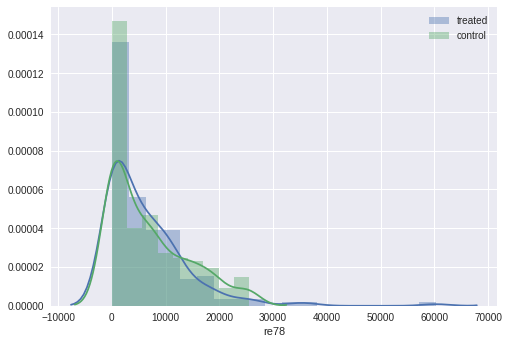

In [4]:
df_lalonde_treated = df_lalonde[df_lalonde.treat == 1]
df_lalonde_control = df_lalonde[df_lalonde.treat == 0]

#does a distplot makes sense in this situation (maybe an histogram would be better)
sns.distplot(df_lalonde_treated["re78"], label="treated")
sns.distplot(df_lalonde_control["re78"], label="control")
plt.legend()
df_summary = pd.DataFrame()
df_summary["treated"] = df_lalonde_treated["re78"].describe()
df_summary["control"] = df_lalonde_control["re78"].describe()
df_summary

### 2. A closer look at the data

TODO:
- For categorical features, plot them as a barplot 
- Add legend to all plots
- Add Axis labels
- Repond to the question
- Correctly subplot more than 9 plot

In [5]:
def is_categoric(feature):
    """Return true if the feature pass in argument is of type categorical"""
    return feature in ['black', 'hispan', 'married', 'nodegree']

def compare_feature(df,feature, ax=None):
    """Return a description of the feature conditioned on the treatement and plot
    the distribution of the data for the treatement and the control"""
    df_treated = df[df.treat == 1]
    df_control = df[df.treat == 0]
    if is_categoric(feature):
        #plot a bar plot
        sns.barplot(df['treat'], df[feature], ax=ax)
    else:
        sns.distplot(df_control[feature], label="control", ax=ax)
        sns.distplot(df_treated[feature], label="treated", ax=ax)
    ax.legend()
    df_summary = pd.DataFrame()
    df_summary[(feature, "treated")] = df_treated[feature].describe()
    df_summary[(feature, "control")] = df_control[feature].describe()
    df_summary.columns = pd.MultiIndex.from_tuples([(feature,'treated'),(feature,'control')], names=['feature', 'treat'])
    return df_summary

def get_features(df):
    features = list(df.columns)
    features.remove('treat')
    return features

def compare_all_feature(df):
    df_all_summary = pd.DataFrame()
    features = get_features(df)
    nb_col = 3
    nb_row = int(np.ceil(len(features)/nb_col))
    print(f'rows: {nb_row} & cols: {nb_col} for nb_feature: {len(features)}')
    fig, axes = plt.subplots(nb_row,nb_col, figsize=(20,20))
    for i, f in enumerate(features):
        x = int(i/nb_col)
        y = i%nb_col
        #print(f'x: {x} & y: {y}')
        df_temp = compare_feature(df, f, axes[x, y])
        df_all_summary = pd.concat([df_all_summary, df_temp], axis=1)
    
    return df_all_summary

rows: 3 & cols: 3 for nb_feature: 9


feature         age                    educ                   black  \
treat       treated     control     treated     control     treated   
count    185.000000  429.000000  185.000000  429.000000  185.000000   
mean      25.816216   28.030303   10.345946   10.235431    0.843243   
std        7.155019   10.786653    2.010650    2.855238    0.364558   
min       17.000000   16.000000    4.000000    0.000000    0.000000   
25%       20.000000   19.000000    9.000000    9.000000    1.000000   
50%       25.000000   25.000000   11.000000   11.000000    1.000000   
75%       29.000000   35.000000   12.000000   12.000000    1.000000   
max       48.000000   55.000000   16.000000   18.000000    1.000000   

feature                  hispan                 married              \
treat       control     treated     control     treated     control   
count    429.000000  185.000000  429.000000  185.000000  429.000000   
mean       0.202797    0.059459    0.142191    0.189189    0.512821   
std        0.402552    0.237124    0.349654    0.392722    0.500419   
min        0.000000    0.000000    0.000000    0.000000    0.000000   
25%        0.000000    0.000000    0.000000    0.000000    0.000000   
50%        0.000000    0.000000    0.000000    0.000000    1.000000   
75%        0.000000    0.000000    0.000000    0.000000    1.000000   
max        1.000000    1.000000    1.000000    1.000000    1.000000   

feature    nodegree                      re74                        re75  \
treat       treated     control       treated       control       treated   
count    185.000000  429.000000    185.000000    429.000000    185.000000   
mean       0.708108    0.596737   2095.573689   5619.236506   1532.055314   
std        0.455867    0.491126   4886.620353   6788.750796   3219.250870   
min        0.000000    0.000000      0.000000      0.000000      0.000000   
25%        0.000000    0.000000      0.000000      0.000000      0.000000   
50%        1.000000    1.000000      0.000000   2547.047000      0.000000   
75%        1.000000    1.000000   1291.468000   9277.128000   1817.284000   
max        1.000000    1.000000  35040.070000  25862.320000  25142.240000   

feature                        re78                
treat         control       treated       control  
count      429.000000    185.000000    429.000000  
mean      2466.484443   6349.143530   6984.169742  
std       3291.996183   7867.402218   7294.161791  
min          0.000000      0.000000      0.000000  
25%          0.000000    485.229800    220.181300  
50%       1086.726000   4232.309000   4975.505000  
75%       3881.419000   9642.999000  11688.820000  
max      18347.230000  60307.930000  25564.670000

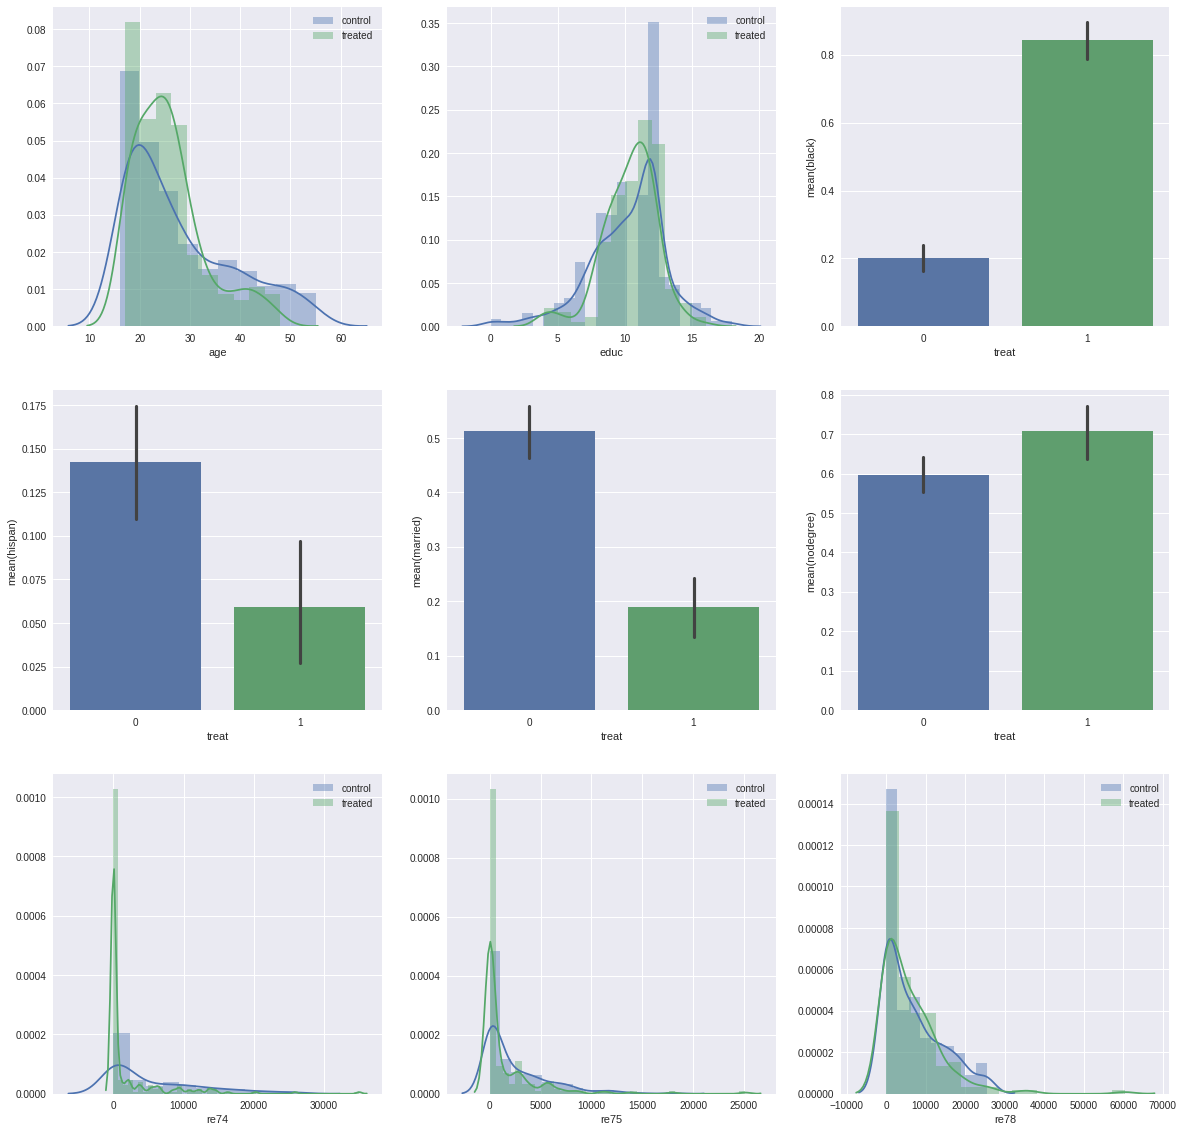

In [6]:
compare_all_feature(df_lalonde)

### 3. A propensity score model

In order to have a logistic regression that overfit as much as possible we augmented the max_iter parameter, and chose the l1 penality which give use a sligly better score on the training set 


TODO:
- Explain why I choose l1 penalty and a max_iteration (to overfit)

In [7]:
from sklearn import linear_model
logistic = linear_model.LogisticRegression()#(penalty='l1', max_iter=1000000000, C=100000000000000)

In [8]:
#finding the probaility of have receive the treatement given the covariate (features) (this is call the propensity score)
X = df_lalonde[get_features(df_lalonde)]
y = df_lalonde['treat']
logistic.fit(X, y)
df_lalonde['propensity'] = logistic.predict_proba(X)[:,1]
print(f'The logistic regression score : {logistic.score(X, y)}')
df_lalonde.head()

The logistic regression score : 0.8045602605863192


,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78,propensity
id,,,,,,,,,,,
NSW1,1,37,11,1,0,1,1,0.0,0.0,9930.0460,0.458074
NSW2,1,22,9,0,1,0,1,0.0,0.0,3595.8940,0.151980
NSW3,1,30,12,1,0,0,0,0.0,0.0,24909.4500,0.750966
NSW4,1,27,11,1,0,0,1,0.0,0.0,7506.1460,0.674020
NSW5,1,33,8,1,0,0,1,0.0,0.0,289.7899,0.670590


### 4. Balancing the dataset via matching


TODO:
- Compare the features-value distributions between groups 
- Are you closer to being able to draw valid conclusions now than you were before? YES but NO

In [9]:
from munkres import Munkres
from scipy.optimize import linear_sum_assignment

In [10]:
def create_cost_matrix(treated, control):
    """ Return the cost matrix between the two arrays
        Each entry (i,j) in the cost matrix represent the distance from 
        node i to node j"""
    cost = np.zeros([len(treated), len(control)])
    for i, t in enumerate(treated):
        for j, c in enumerate(control):
            cost[i, j] = abs(t-c)
    return cost

def propensity_matching(df):
    """Return the treated and a subset of control composed from the 
    one matching between the closest point in the control dataset"""
    df_treated = df[df['treat']==1]
    df_control = df[df['treat']==0]
    cost_matrix = create_cost_matrix(df_treated['propensity'], df_control['propensity'])
    #m = Munkres()
    #match = dict(m.compute(cost_matrix))
    row_ind, col_ind = linear_sum_assignment(cost_matrix)
    #index = [match[i] for i in range(len(match))]
    return pd.concat([df_treated, df_control.iloc[col_ind]])
    
i=3 #120
df_balanced  = propensity_matching(df_lalonde)
df_balanced.iloc[[i, i+185]]

,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78,propensity
id,,,,,,,,,,,
NSW4,1,27,11,1,0,0,1,0.000,0.0000,7506.146,0.674020
PSID277,0,19,10,1,0,0,1,1056.045,205.8871,0.000,0.668007


rows: 4 & cols: 3 for nb_feature: 10


feature         age                    educ                   black  \
treat       treated     control     treated     control     treated   
count    185.000000  185.000000  185.000000  185.000000  185.000000   
mean      25.816216   23.167568   10.345946    9.864865    0.843243   
std        7.155019    9.337805    2.010650    2.775692    0.364558   
min       17.000000   16.000000    4.000000    0.000000    0.000000   
25%       20.000000   17.000000    9.000000    8.000000    1.000000   
50%       25.000000   19.000000   11.000000   10.000000    1.000000   
75%       29.000000   24.000000   12.000000   12.000000    1.000000   
max       48.000000   55.000000   16.000000   17.000000    1.000000   

feature                 hispan                 married              \
treat      control     treated     control     treated     control   
count    185.00000  185.000000  185.000000  185.000000  185.000000   
mean       0.47027    0.059459    0.102703    0.189189    0.183784   
std        0.50047    0.237124    0.304394    0.392722    0.388359   
min        0.00000    0.000000    0.000000    0.000000    0.000000   
25%        0.00000    0.000000    0.000000    0.000000    0.000000   
50%        0.00000    0.000000    0.000000    0.000000    0.000000   
75%        1.00000    0.000000    0.000000    0.000000    0.000000   
max        1.00000    1.000000    1.000000    1.000000    1.000000   

feature    nodegree                      re74                        re75  \
treat       treated     control       treated       control       treated   
count    185.000000  185.000000    185.000000    185.000000    185.000000   
mean       0.708108    0.675676   2095.573689   2268.386180   1532.055314   
std        0.455867    0.469392   4886.620353   4266.737051   3219.250870   
min        0.000000    0.000000      0.000000      0.000000      0.000000   
25%        0.000000    0.000000      0.000000      0.000000      0.000000   
50%        1.000000    1.000000      0.000000    336.993900      0.000000   
75%        1.000000    1.000000   1291.468000   2217.890000   1817.284000   
max        1.000000    1.000000  35040.070000  21918.320000  25142.240000   

feature                        re78                propensity              
treat         control       treated       control     treated     control  
count      185.000000    185.000000    185.000000  185.000000  185.000000  
mean      1670.138671   6349.143530   5828.584903    0.555453    0.377476  
std       2734.930726   7867.402218   6094.306306    0.206467    0.234568  
min          0.000000      0.000000      0.000000    0.036175    0.036219  
25%          0.000000    485.229800    237.914000    0.451977    0.183745  
50%        470.854800   4232.309000   4112.513000    0.647735    0.239343  
75%       1976.516000   9642.999000   8957.978000    0.695839    0.650508  
max      13776.530000  60307.930000  25564.670000    0.885622    0.792162

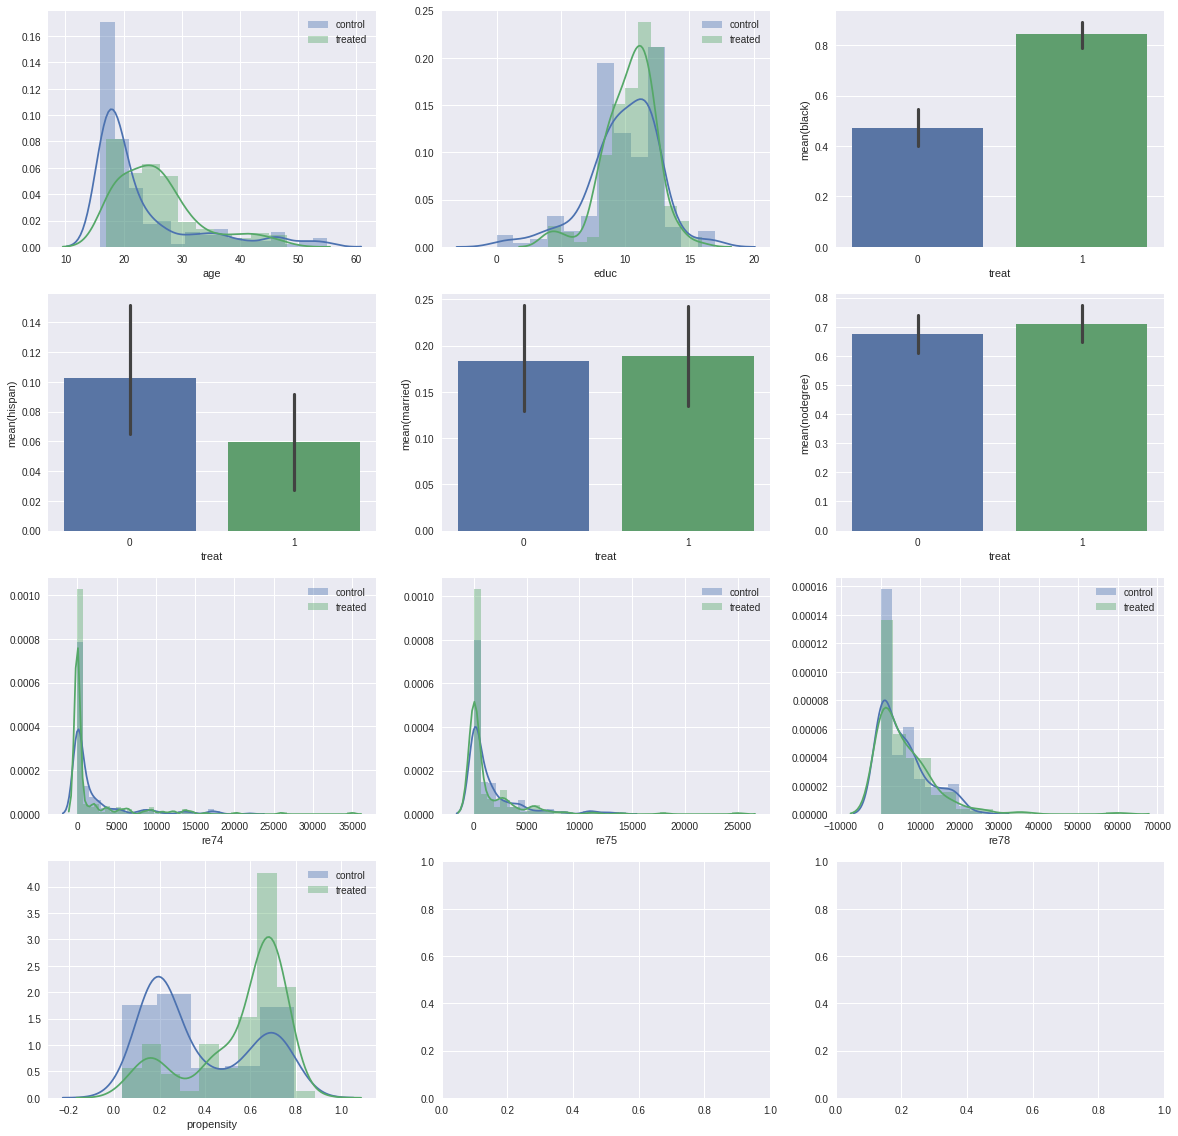

In [11]:
compare_all_feature(df_balanced)

### 5. Balancing the groups further
If there isn't any good enough matching for some point in the treated set to the control set then it is imposible to do better

We can for each pair decide if we keep it based on this decision : $ | p_t - p_c | < \epsilon $ Then based on this decision keep only the treated point and rerun the algorithm to find if we can find even closer control point that the one that was initaly maped

TODO:
- Explain what could be done (take only the overlaping regions)
- Give an contreat example for the balanced dataset that show two different propensity score
- Find a better plot to show the masse distribution
- Label axis
- Explain the cut=0
- Implement our better matching algo

Above a propensity score of 0.5, we have only 64 control observation and 129 treated observation


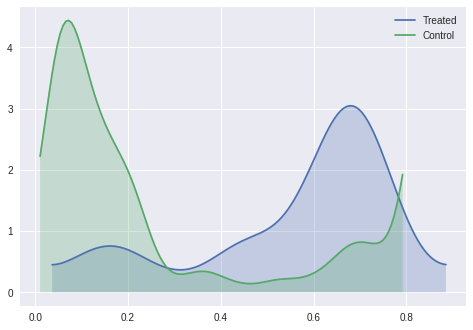

In [12]:
prop_score_threshold = 0.5
#plt.scatter(df_lalonde['propensity'], df_lalonde['treat'])
length_treat = len(df_lalonde[(df_lalonde['propensity']>prop_score_threshold) & (df_lalonde['treat'] == 1)])
length_cont = (len(df_lalonde[(df_lalonde['propensity']>prop_score_threshold) & (df_lalonde['treat'] == 0)]))
print(f'Above a propensity score of {prop_score_threshold}, we have only {length_cont} \
control observation and {length_treat} treated observation')
## TODO more work is needed
sns.kdeplot(df_lalonde[df_lalonde.treat==1]['propensity'], shade=True, label='Treated', cut=0)
sns.kdeplot(df_lalonde[df_lalonde.treat==0]['propensity'], shade=True, label='Control', cut=0)
plt.show()

### 6. A less naive analysis

TODO:
- Call the same function as above on the futher balanced group
- Analyse what we see

# Question 2: Applied ML

TODO:
- Clean the code (remove some useless cells, put funciton in a separate python file)

### 1. Loading the DataSet

TODO:
- Explain our preprocessing on the text
- Find a way to map the feature with it's name (real word)
- Explain why I don't split into 3 set (but only test and train set)

In [13]:
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import randint as sp_randint
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from time import time 

[Pipline](http://scikit-learn.org/stable/tutorial/text_analytics/working_with_text_data.html)

In [14]:
# limit the list of categories to make running this example faster.
cat = None#= ['comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware']#['alt.atheism', 'talk.religion.misc', 'sci.space']
news_groups = fetch_20newsgroups(random_state=1, subset='train', categories=cat)

In [15]:
vectorizer = TfidfVectorizer(min_df=1, lowercase=True, 
                             strip_accents="unicode", stop_words="english", ngram_range=(1, 1))
#preprocessor

X = vectorizer.fit_transform(news_groups.data)
y = news_groups.target
print(f'X shape is : {X.shape} and y shape is: {y.shape}')

X shape is : (11314, 129790) and y shape is: (11314,)


In [16]:
#vectorizer.get_feature_names()[-1000:]

In [17]:
#Spliting dataset into train, test and validation sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

In [18]:
clf = RandomForestClassifier() #(n_estimators=10, max_depth=500, random_state=42)

In [19]:
# specify parameters and distributions to sample from
param_dist = {
    "n_estimators" : sp_randint(10, 200),
    "max_depth": [3, None],
    "max_features": sp_randint(1, 11),
    "min_samples_split": sp_randint(2, 11),
    "min_samples_leaf": sp_randint(1, 11),
    "bootstrap": [True, False],
    "criterion": ["gini", "entropy"]}

In [20]:
# run randomized search
n_iter_search = 3#20
random_search = RandomizedSearchCV(clf, param_distributions=param_dist, cv=10,
                                   n_iter=n_iter_search, n_jobs=-1, verbose=1)
start = time()
random_search.fit(X_train, y_train)
print("RandomizedSearchCV took %.2f seconds for %d candidates"
      " parameter settings." % ((time() - start), n_iter_search))

Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   20.4s finished


RandomizedSearchCV took 21.32 seconds for 3 candidates parameter settings.


In [21]:
random_search.best_estimator_.score(X_test, y_test)

0.55742049469964661

In [48]:
def save_params(params, filename):
    f = open(filename,'w')
    f.write(str(params))
    f.close()
    return params
def load_params(filename):
    f = open(filename,'r')
    params = eval(f.read())
    return params
def get_forest_from_params(params):
    forest = RandomForestClassifier()
    forest.set_params(**params)
    return forest

In [49]:
#Save the parameters in a file to speedup time for next execution
save_params(random_search.best_params_, 'my_params.dict')
params = load_params('0.89%_params.dict')
best_forest = get_forest_from_params(params)
best_forest.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features=2, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=10,
            min_weight_fraction_leaf=0.0, n_estimators=174, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [50]:
#interpereting feature importance
from sklearn import metrics
#best_forest = random_search.best_estimator_
predict = best_forest.predict(X_test)
report = metrics.classification_report(y_test, predict,
                              target_names=news_groups.target_names)
print(report)

                          precision    recall  f1-score   support

             alt.atheism       0.91      0.91      0.91        43
           comp.graphics       0.87      0.92      0.89        74
 comp.os.ms-windows.misc       0.83      0.83      0.83        76
comp.sys.ibm.pc.hardware       0.74      0.82      0.78        55
   comp.sys.mac.hardware       0.95      0.83      0.89        65
          comp.windows.x       0.87      0.91      0.89        57
            misc.forsale       0.75      0.88      0.81        58
               rec.autos       0.91      0.87      0.89        67
         rec.motorcycles       0.96      0.96      0.96        70
      rec.sport.baseball       0.93      0.98      0.95        53
        rec.sport.hockey       0.95      0.97      0.96        58
               sci.crypt       0.98      0.96      0.97        55
         sci.electronics       0.94      0.88      0.91        69
                 sci.med       1.00      0.89      0.94        70
         

In [51]:
print(metrics.confusion_matrix(y_test, predict))

[[39  0  0  0  0  0  0  0  0  1  0  0  0  0  0  3  0  0  0  0]
 [ 0 68  1  2  0  0  2  0  0  0  0  0  0  0  1  0  0  0  0  0]
 [ 0  3 63  3  0  4  2  0  0  0  0  0  1  0  0  0  0  0  0  0]
 [ 0  0  4 45  1  0  3  0  0  0  1  0  1  0  0  0  0  0  0  0]
 [ 0  0  3  5 54  0  2  0  0  1  0  0  0  0  0  0  0  0  0  0]
 [ 0  2  0  0  1 52  0  0  0  1  1  0  0  0  0  0  0  0  0  0]
 [ 0  0  1  1  1  0 51  3  0  0  0  0  1  0  0  0  0  0  0  0]
 [ 0  0  1  0  0  1  2 58  3  1  0  0  1  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  1  2 67  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0 52  1  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  1  1  0  0  0 56  0  0  0  0  0  0  0  0  0]
 [ 0  1  0  0  0  0  1  0  0  0  0 53  0  0  0  0  0  0  0  0]
 [ 0  0  2  4  0  0  1  0  0  0  0  0 61  0  1  0  0  0  0  0]
 [ 1  2  1  1  0  0  2  0  0  0  0  0  0 62  0  1  0  0  0  0]
 [ 0  1  0  0  0  1  0  0  0  0  0  0  0  0 44  0  0  0  0  0]
 [ 1  1  0  0  0  0  0  0  0  0  0  0  0  0  0 55  0  0

From the confusion matrix above we can see that 8 and 9 are sometime interchange which is understable due to the fact that they are sharing a related topic

Same can be say for Christianism and religion (cat 14 and 19)

Same for category 3 4 which both talks about hardware


In [52]:
importance = zip(best_forest.feature_importances_, vectorizer.get_feature_names())
sorted(importance, reverse=True)[:10]

[(0.0015649794424526776, 'sale'),
 (0.0013353452346654617, 'windows'),
 (0.00076581080777884632, 'writes'),
 (0.00074777241415515923, 'team'),
 (0.00072809438253881322, 'subject'),
 (0.00072563665893091796, 'host'),
 (0.00069251409659864779, 'game'),
 (0.00068928408248386877, 'edu'),
 (0.00068803991150865544, 'baseball'),
 (0.00068264668250150569, 'bike')]